# read in raw data, apply selection criteria, generate summary table and plot values

In [2]:
import os
import gdown
import zipfile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from IPython.display import display
from PyOptimalInterpolation import get_parent_path
from PyOptimalInterpolation.utils import config_func, stats_on_vals #, WGS84toEASE2_New, date_from_datetime
from PyOptimalInterpolation.plot_utils import plot_pcolormesh, plot_hist

pd.set_option('display.max_columns', 200)

# read data - parameters / configuration

In [3]:
# location of directory containing raw data files.
# - change as needed
data_dir = get_parent_path("data", "ocean_elev_gpod_raw_tsv")

# for each 'source' specify one or more files to read in
file_map = {
    "CS2": [
        os.path.join(data_dir, "CS2_SAR.tsv"),
        os.path.join(data_dir, "CS2_SARIN.tsv")
    ],
    "S3A": os.path.join(data_dir, "S3A.tsv"),
    "S3B": os.path.join(data_dir, "S3B.tsv")
}

# check if exist
all_exist = True
for source, file in file_map.items():
    if not os.path.exists(file):
        print("source: {source}\nfile: {file}\ndoes not exist - download")
    all_exist &= os.path.exists(file)

# if the data does not exist, download and unzip
if not all_exist:
    print("*" * 10)
    print("(some) data is missing, fetching...")

    id = "17FVLxpRu7ytx0Vvy6aoylW-1VNEXM_H1"
    zip = "ocean_elev_gpod_raw_tsv.zip"
    tmp_dir = os.path.dirname(data_dir)

    # put data in data dir in repository
    output = os.path.join(tmp_dir, zip)
    gdown.download(id=id, output=output, use_cookies=False)

    # un zip to path
    print("unzipping")
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(path=tmp_dir)

    # remove zip folder
    os.remove(os.path.join(tmp_dir, zip))


# keyword arguments to provide to pd.read_csv
read_csv_kwargs = {
        "sep": "\t"
    }

verbose = 3

# Read Data

In [4]:

res = []
for source, files in file_map.items():

    if isinstance(files, str):
        files = [files]

    assert isinstance(files, (list, tuple, np.array)), "files expected to be list or tuple"

    for file in files:
        assert os.path.exists(file), f"source: {source}, file: {file} does not exist"
        print(f"{'-' * 10}\nsource: {source}\nfile:{file}")
        _ = pd.read_csv(file, **read_csv_kwargs)
        # HARDCODED: adding a 'source' column
        _['source'] = source

    res += [_]

# concat all results
df = pd.concat(res)

print("head of data:")
print(df.head(3))

----------
source: CS2
file:/mnt/hd1/data/ocean_elev/GPOD/CS2_SAR.tsv
----------
source: CS2
file:/mnt/hd1/data/ocean_elev/GPOD/CS2_SARIN.tsv
----------
source: S3A
file:/mnt/hd1/data/ocean_elev/GPOD/S3A.tsv
----------
source: S3B
file:/mnt/hd1/data/ocean_elev/GPOD/S3B.tsv


# add / transform columns - parameters

In [5]:

col_funcs = {
    # convert lon, lat to x,y with EASE2.0 projection
    # "x,y": {
    #     # func can be defined function
    #     "func": WGS84toEASE2_New,
    #     "col_args": ["lon", "lat"],
    #     "out_cols": ["x", "y"]
    # },
    # get date in YYYYMMDD format from 'datetime' column
    "date": {
        # or it can be a string - which eval will act on
        "func": "date_from_datetime",
        "col_kwargs": {"dt": "datetime"}
    },
    # convert datetime to column to datetime64
    "datetime": {
        "func": lambda x: x.astype('datetime64'),
        "col_args": "datetime"
    },
    # elevation minus mean sea surface
    "elev-mss": {
        "func": "-",
        "col_args": ["elev", "mss"]
    }
}

In [6]:

print("*" * 20)

# apply column functions
for new_col, col_fun in col_funcs.items():

    # including out_cols to allow for multiple column output
    # - an alternative could be to parse new_col to get multiple columns
    # - e.g. "x,y" -> ["x", "y"]
    # - NOTE: after popping 'out_cols' will no longer exist in dict!
    new_col = col_fun.pop('out_cols', new_col)

    # add new column
    if verbose >= 3:
        print(f"adding new_col: {new_col}")
        print(f"using: {col_fun}")

    _ = config_func(df=df,
                    **col_fun)
    # allow for multiple column assignment
    if isinstance(new_col, (list, tuple)):
        for nc_idx, nc in enumerate(new_col):
            df[nc] = _[nc_idx]
    else:
        df[new_col] = _


********************
adding new_col: date
using: {'func': 'date_from_datetime', 'col_kwargs': {'dt': 'datetime'}}
adding new_col: datetime
using: {'func': <function <lambda> at 0x7f81934d3280>, 'col_args': 'datetime'}
adding new_col: elev-mss
using: {'func': '-', 'col_args': ['elev', 'mss']}


# row selection

In [7]:

row_select = [
    # dates after "2020-03-01"
    {"func": ">=", "col_args": "datetime", "args": np.datetime64("2020-03-01")},
    # dates before "2020-04-01"
    {"func": "<", "col_args": "datetime", "args": np.datetime64("2020-04-01")}
    # keep only: data["elev-mss"] <= 75
    # {"func": "<=", "col_args": "elev-mss", "args": 75}
]


In [8]:
select = np.ones(len(df), dtype=bool)

print("selecting rows:")
for sl in row_select:
    # print(sl)
    if verbose >= 3:
        print(sl)
    select &= config_func(df=df, **sl)

# select subset of data
if verbose >= 3:
    print(f"selecting {select.sum()}/{len(select)} rows")
df = df.loc[select, :]


selecting rows:
{'func': '>=', 'col_args': 'datetime', 'args': numpy.datetime64('2020-03-01')}
{'func': '<', 'col_args': 'datetime', 'args': numpy.datetime64('2020-04-01')}
selecting 740595/2664162 rows


# summary table

In [11]:
print("*" * 20)
print("summary / stats table on metric (use for trimming)")

val_col = "elev-mss"
vals = df[val_col].values
# vals = vals[(vals < 5) & (vals > -5) ]
stats_df = stats_on_vals(vals=vals, name=val_col,
                         qs=[0.01, 0.05] + np.arange(0.1, 1.0, 0.1).tolist() + [0.95, 0.99])

# print(stats_df)
display(stats_df)

********************
summary / stats table on metric (use for trimming)
          measure      size  num_not_nan  num_inf      min       mean  \
elev-mss      NaN  740595.0     740595.0      0.0 -95.0999  19.296823   

                max         std      skew    kurtosis   q0.01    q0.05  \
elev-mss  2313.5229  121.422794  9.432224  112.576186 -2.5379 -0.42073   

           q0.10   q0.20   q0.30   q0.40   q0.50   q0.60   q0.70   q0.80  \
elev-mss -0.0896  0.1124  0.2029  0.2663  0.3218  0.3779  0.4424  0.5379   

           q0.90     q0.95      q0.99  
elev-mss  0.8441  11.59464  599.64669  


,elev-mss
measure,NaN
size,740595.000000
num_not_nan,740595.000000
num_inf,0.000000
min,-95.099900
mean,19.296823
max,2313.522900
std,121.422794
skew,9.432224
kurtosis,112.576186


# plot (selected) values

In [12]:

print("*" * 20)
print("visualise values")

plot_select = [
    # keep only: data["elev-mss"] <= 75
    # {"func": "==", "col_args": "source", "args": "CS2"},
    {"func": "<=", "col_args": "elev-mss", "args": 5},
    {"func": ">=", "col_args": "elev-mss", "args": -5}
]
plt_title = "all sats"
sup_title = "March 2020 Raw Obs"
plot_col = val_col
lon_col, lat_col = 'lon', 'lat'
scatter_plot_size = 2

vmin, vmax = None, None

select = np.ones(len(df), dtype=bool)

print("selecting rows (for plotting)")
for sl in plot_select:
    # print(sl)
    if verbose >= 3:
        print(sl)
    select &= config_func(df=df, **sl)

# select subset of data
if verbose >= 3:
    print(f"selecting {select.sum()}/{len(select)} rows for plot")
pltdf = df.loc[select, :]


********************
visualise values
selecting rows (for plotting)
{'func': '<=', 'col_args': 'elev-mss', 'args': 5}
{'func': '>=', 'col_args': 'elev-mss', 'args': -5}
selecting 696294/740595 rows for plot


/home/buddy/miniconda3/envs/PyOptimalInterpolation/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/buddy/miniconda3/envs/PyOptimalInterpolation/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/buddy/miniconda3/envs/PyOptimalInterpolation/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_m

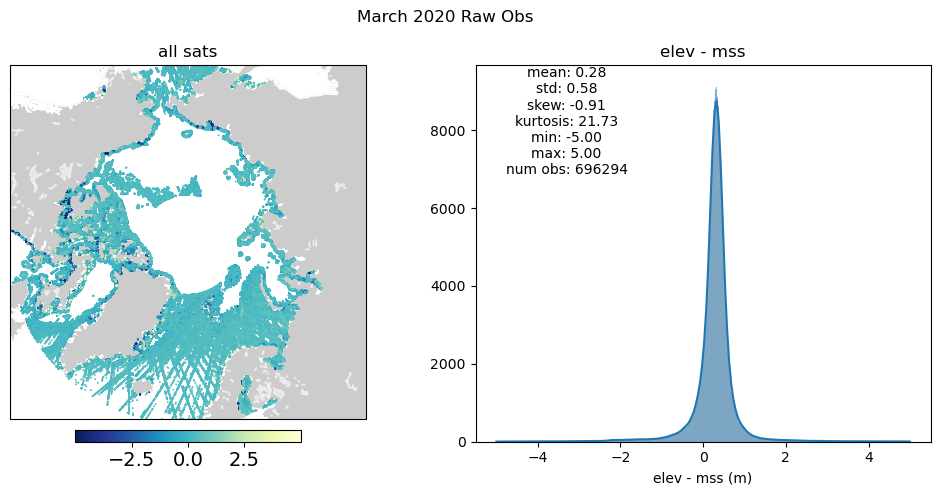

In [13]:

figsize = (10, 5)
fig = plt.figure(figsize=figsize)
fig.suptitle(sup_title)

nrows, ncols = 1, 2

# first plot: heat map of observations
ax = fig.add_subplot(1, 2, 1,
                     projection=ccrs.NorthPolarStereo())

plot_pcolormesh(ax=ax,
                lon=pltdf[lon_col].values,
                lat=pltdf[lat_col].values,
                plot_data=pltdf[plot_col].values,
                fig=fig,
                title=plt_title,
                vmin=vmin,
                vmax=vmax,
                cmap='YlGnBu_r',
                # cbar_label=cbar_labels[midx],
                scatter=True,
                s=scatter_plot_size)

ax = fig.add_subplot(1, 2, 2)

plot_hist(ax=ax,
          data=pltdf[plot_col].values,
          ylabel="",
          stats_values=['mean', 'std', 'skew', 'kurtosis', 'min', 'max', 'num obs'],
          title=f"elev - mss",
          xlabel="elev - mss (m)",
          stats_loc=(0.2, 0.85))

plt.tight_layout()
plt.show()
